# **Homework 2**

## **Libraries**

In [1]:
import os
import cv2
import scipy
import numpy as np 
import tensorflow as tf
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.regularizers import l2, l1, l1_l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

2024-01-14 11:30:13.254900: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 11:30:13.256719: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 11:30:13.281334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 11:30:13.281356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 11:30:13.281996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## **Settings**

In [2]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## **Data**

### **Data Augmentation**

In [3]:
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.2
)

datagen_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=False,
    vertical_flip=False,
)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=False,
    rescale=1./255,
    fill_mode='nearest',
)

datablanket = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### **Data Load**

Without augmentation

In [5]:
Train = datablanket.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

Val = datablanket.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=20,
    class_mode='categorical',
    subset = 'validation',
)

Test = datablanket.flow_from_directory(
    'test',
    target_size=(96,96),
    batch_size=20,
    class_mode='categorical',
)

train_labels = []
train_labels = Train.classes
num_classes = Train.num_classes
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

Found 5096 images belonging to 5 classes.
Found 1273 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.


With augmentation

In [4]:
Train = datagen_train.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

Val = datagen_val.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

Test = datablanket.flow_from_directory(
    'test',
    target_size=(96,96),
    batch_size=20,
    class_mode='categorical'
)

train_labels = []
train_labels = Train.classes
num_classes = Train.num_classes
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

Found 5096 images belonging to 5 classes.
Found 1273 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.


Visualization

In [5]:
def visualize_dataset(dataset, num_samples=5):
    for images, labels in dataset:
        num_samples_batch = min(num_samples, len(images))
        fig, ax = plt.subplots(1, num_samples_batch, figsize=(20, 20))
        
        for i in range(num_samples_batch):
            ax[i].imshow((images[i] * 96).astype("uint8"))  # Remove the rescaling here
            ax[i].set_title(f"Label: {labels[i]}")
            ax[i].axis("off")
        
        plt.show()
        break

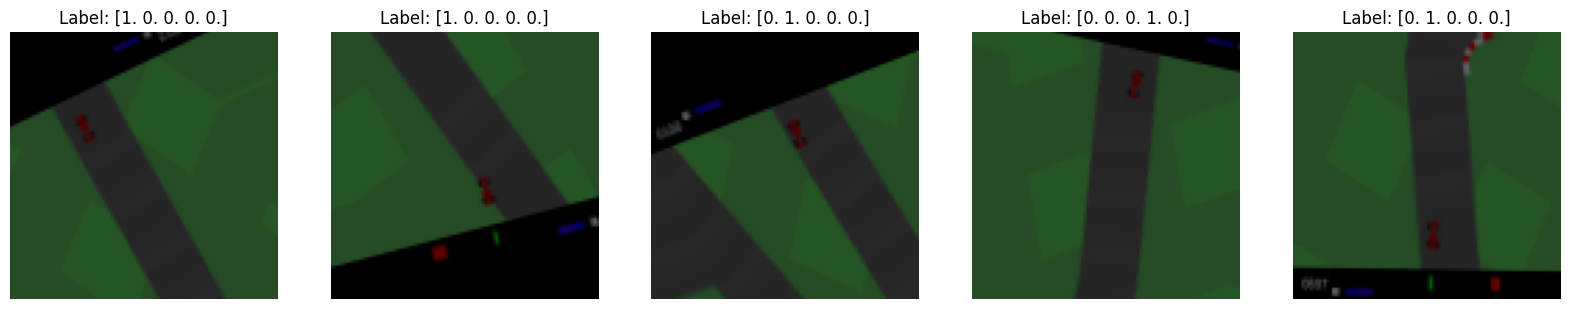

In [6]:
visualize_dataset(Train)

## **Model**

### **Architecture 1**

In [7]:
model = Sequential()

# Layers
# Feature Learning
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3), padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.05))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))


# Classification
model.add(GlobalAveragePooling2D())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.35)) # Dropout layer to reduce overfitting
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.35)) # Dropout layer to reduce overfitting

num_classes = 5
model.add(Dense(num_classes, activation='softmax'))

### **Architecture 2**

In [9]:
model = Sequential()

# Feature learning
model.add(Conv2D(32, 3, activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization()) 
model.add(Dropout(0.05))

model.add(Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(1256, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

# classification
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

num_classes = 5
model.add(Dense(num_classes, activation='softmax'))

### **Arch 3**


In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 3), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001) ))
model.add(Dropout(0.35))

num_classes = 5
model.add(Dense(num_classes, activation='softmax'))

### **Model settings**

Optimizer

In [8]:
# Adam
# beta_1 = 0.9
# beta_2 = 0.999
optimizer = Adam(learning_rate=0.0001) #, beta_1=beta_1, beta_2=beta_2)
loss = keras.losses.CategoricalCrossentropy()

In [ ]:
# SGD
optimizer=SGD(learning_rate=0.01, momentum=0.9)

Compile and Summary

In [9]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

for layer in model.layers:
    print(f"{layer.name}: Input shape - {layer.input_shape}")
    print(f"{layer.name}: Output shape - {layer.output_shape}")

conv2d: Input shape - (None, 96, 96, 3)
conv2d: Output shape - (None, 94, 94, 32)
batch_normalization: Input shape - (None, 94, 94, 32)
batch_normalization: Output shape - (None, 94, 94, 32)
activation: Input shape - (None, 94, 94, 32)
activation: Output shape - (None, 94, 94, 32)
max_pooling2d: Input shape - (None, 94, 94, 32)
max_pooling2d: Output shape - (None, 47, 47, 32)
dropout: Input shape - (None, 47, 47, 32)
dropout: Output shape - (None, 47, 47, 32)
conv2d_1: Input shape - (None, 47, 47, 32)
conv2d_1: Output shape - (None, 45, 45, 64)
batch_normalization_1: Input shape - (None, 45, 45, 64)
batch_normalization_1: Output shape - (None, 45, 45, 64)
activation_1: Input shape - (None, 45, 45, 64)
activation_1: Output shape - (None, 45, 45, 64)
max_pooling2d_1: Input shape - (None, 45, 45, 64)
max_pooling2d_1: Output shape - (None, 22, 22, 64)
dropout_1: Input shape - (None, 22, 22, 64)
dropout_1: Output shape - (None, 22, 22, 64)
conv2d_2: Input shape - (None, 22, 22, 64)
conv2d_2

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        1

## **Fitting**

In [11]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
class_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True)

Fit

In [12]:
hist = model.fit(
    Train,
    epochs=20,
    callbacks=[tensorboard_callback, early_stopping], 
    validation_data=Val, 
    validation_steps=Val.samples // Val.batch_size, 
    class_weight=class_weights_dict)

Epoch 1/20
255/255 [==============================] - 21s 79ms/step - loss: 7.4117 - accuracy: 0.2369 - val_loss: 6.7915 - val_accuracy: 0.0579
Epoch 2/20
255/255 [==============================] - 21s 81ms/step - loss: 6.1111 - accuracy: 0.2637 - val_loss: 5.6580 - val_accuracy: 0.0603
Epoch 3/20
255/255 [==============================] - 21s 84ms/step - loss: 5.1178 - accuracy: 0.2832 - val_loss: 4.7151 - val_accuracy: 0.3262
Epoch 4/20
255/255 [==============================] - 21s 84ms/step - loss: 4.4080 - accuracy: 0.2910 - val_loss: 4.1129 - val_accuracy: 0.2286
Epoch 5/20
255/255 [==============================] - 21s 84ms/step - loss: 3.9085 - accuracy: 0.2993 - val_loss: 3.7355 - val_accuracy: 0.1802
Epoch 6/20
255/255 [==============================] - 21s 82ms/step - loss: 3.5308 - accuracy: 0.3085 - val_loss: 3.3200 - val_accuracy: 0.3667
Epoch 7/20
255/255 [==============================] - 21s 83ms/step - loss: 3.2207 - accuracy: 0.3271 - val_loss: 3.1228 - val_accuracy:

KeyboardInterrupt: 

## **Performance**

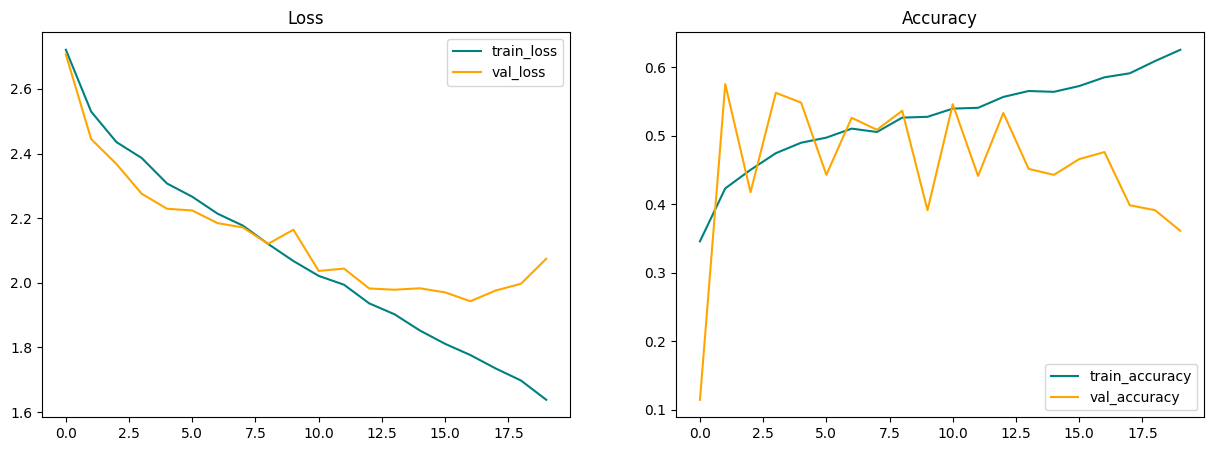

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(hist.history['loss'], color='teal', label='train_loss')
ax1.plot(hist.history['val_loss'], color='orange', label='val_loss')  # Validation loss
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
ax2.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')  # Validation accuracy
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

## **Test**

In [16]:
yhat = model.evaluate(Test)

138/138 [==============================] - 2s 17ms/step - loss: 2.0776 - accuracy: 0.3634


In [17]:
Test = tf.keras.utils.image_dataset_from_directory('test')
test_iterator = Test.as_numpy_iterator()

all_X_test = []
all_y_test = []

for test_batch in test_iterator:
    X_test_batch, y_test_batch = test_batch
    X_test_normalized_batch = X_test_batch/96.0
    yhat_batch = model.predict(X_test_normalized_batch)
    all_X_test.append(X_test_normalized_batch)
    all_y_test.append(y_test_batch)

X_test_normalized = np.concatenate(all_X_test)
y_test = np.concatenate(all_y_test)

test_iterator = Test.as_numpy_iterator()
Test_batch = next(test_iterator)
X_test, y_test = Test_batch
X_test_normalized = X_test/96.0

Found 2749 files belonging to 5 classes.


ValueError: in user code:

    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 96, 96, 3), found shape=(32, 256, 256, 3)


In [18]:
yhat = model.predict(Test)


ValueError: in user code:

    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/leonardo/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 96, 96, 3), found shape=(None, 256, 256, 3)


In [19]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [20]:
pre.update_state(yhat)
re.update_state(yhat)
acc.update_state(yhat)                                    

TypeError: Precision.update_state() missing 1 required positional argument: 'y_pred'

In [21]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.0
